In [54]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
import time
from os import listdir
from os.path import isfile, join
import re

plt.rcParams.update(plt.rcParamsDefault)

# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [55]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.notna',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note'
]

In [56]:
population_df = pd.read_csv('data/statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [57]:
full_df = pd.read_csv('Collecting NPIs Effects - FULL.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'], format='%m/%d/%Y')
full_df['end_date'] = pd.to_datetime(full_df['end_date'], format='%m/%d/%Y')
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)

#full_df = full_df[full_df['start_date'] < '04-01-2020']

provinces_df = full_df[full_df['subregion'].isna() & full_df['region'].notna() & (full_df['region'] != "All")]

federal_df = full_df[full_df['subregion'].isna() & (full_df['region'].isna() | (full_df['region'] == "All"))]

In [58]:
full_df.shape

(2498, 26)

In [59]:
provinces_df.shape

(1245, 26)

In [60]:
federal_df.shape

(68, 26)

In [61]:
full_df.drop(columns=['reviewer']).to_csv('npi_canada.csv')
provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')
federal_df.drop(columns=['reviewer']).to_csv('npi_federal.csv')

# Descriptive Statistics for Paper

In [62]:
print("Number of interventions recorded: ", full_df.shape[0])

Number of interventions recorded:  2498


In [63]:
print("Number of oxford interventions recorded: ", full_df['oxford_government_response_category'].count())

Number of oxford interventions recorded:  1270


In [64]:
n = full_df[~full_df['oxford_government_response_category'].isin(['S8 Fiscal measures', 'S9 Monetary measures (interest rate)', 'S10 Emergency investment in health care', 'S11 Investment in vaccines', 'S12 Testing policy', 'S13 Contact tracing'])]['oxford_government_response_category'].count()
print("Number of oxford interventions in Stringency Index recorded (S1-S7): ", n)

Number of oxford interventions in Stringency Index recorded (S1-S7):  929


In [65]:
n / full_df.shape[0]

0.3718975180144115

In [66]:
print("Number of unique source urls: ", len(full_df['source_url'].unique()))

Number of unique source urls:  1436


In [67]:
print("Number of unique primary source organizations: ", len(full_df['source_organization'].unique()))

Number of unique primary source organizations:  243


In [68]:
oxford_ratio = full_df['oxford_government_response_category'].count() / full_df['intervention_category'].count()
print("% of interventions with oxford classifications: ", oxford_ratio)



% of interventions with oxford classifications:  0.516260162601626


## NPI: Enforcement Categories


In [69]:
len(full_df['enforcement_category'].unique())

6

In [70]:
full_df.groupby(by='enforcement_category').count().max(axis=1).sort_values()

enforcement_category
Arrest              6   
Legal Action        39  
Fines               76  
Refusal of Entry    168 
Not Applicable      2043
dtype: int64

Text(0.5,0,'count')

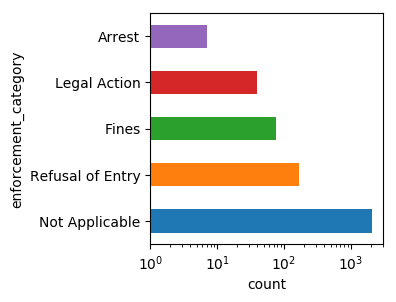

In [71]:
full_df.groupby(by="enforcement_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(3,3))
plt.xlabel('count')

## Target Population Categories

In [72]:
len(full_df['target_population_category'].unique())

17

Text(0.5,0,'count')

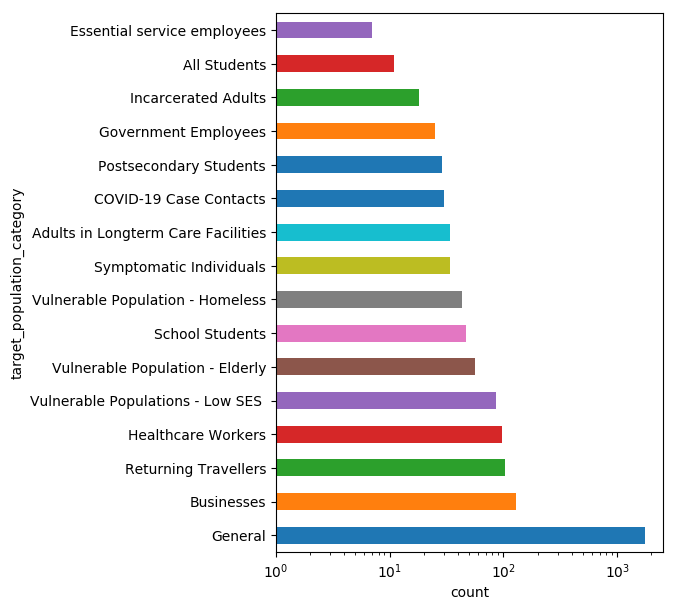

In [73]:
full_df.groupby(by="target_population_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(5,7))
plt.xlabel('count')

## NPI: Intervention Categories

In [74]:
len(full_df['intervention_category'].unique())

63

Lets show examples of the top 15 interventions by count

In [75]:
intervention_counts = pd.DataFrame(full_df.groupby(by='intervention_category').count().max(axis=1))

In [76]:
pd.set_option('display.max_colwidth', -1)

examples = pd.DataFrame(full_df.groupby(by='intervention_category').apply(lambda x: x.sample(1, random_state=3)['intervention_summary'].values[0]))

intervention_counts.merge(examples, left_index=True, right_index=True).sort_values(by='0_x', ascending=False)[0:17]



,0_x,0_y
intervention_category,,
Public Announcement,305,Funding installation of portable toilets at several pull-ouots for commercial truck drivers
General case announcement,201,Announce 14 new cases for total of 1575 in BC
Emergency economic funding,161,Allocate $1.5bn for economic recovery
Social Distancing Announcement,128,Reminders to not travel and to socially distance over holidays approaching
Emergency social services funding,101,Fund to support rental measures
Administrative flexibility,96,Ban retail food and grocery stores from selling bulk items except via gravity feed bins or where staffs dispense the items
Non-essential workplace closure,83,Mandatory closure of all non-essential workplaces
Public event/ meeting cancellation or postponement,76,Suspend bookings for memorial services at Mountain View Cemetery Celebration Hall
Recreational / Entertainment Facility Closure,74,Multiple local YMCA closes in Kelowna


In [77]:
full_df[full_df['oxford_government_response_category'].isna()].groupby(by='intervention_category').count().max(axis=1).sort_values(ascending=False)


intervention_category
Public Announcement                                   202
General case announcement                             135
Administrative flexibility                            75 
Social Distancing Announcement                        56 
Healthcare facility restrictions                      54 
Declaration of emergency (or similar)                 42 
Emergency social services funding                     38 
Health workforce task-shifting                        35 
Public Reassurance                                    34 
Public park closure                                   33 
Recommended self-isolation                            28 
Emergency economic funding                            26 
Improve testing capacity                              26 
Employment Protections                                26 
Social Service provider restrictions                  25 
Creation of command center                            24 
Recreational / Entertainment Facility Closure     

Text(0.5,0,'count')

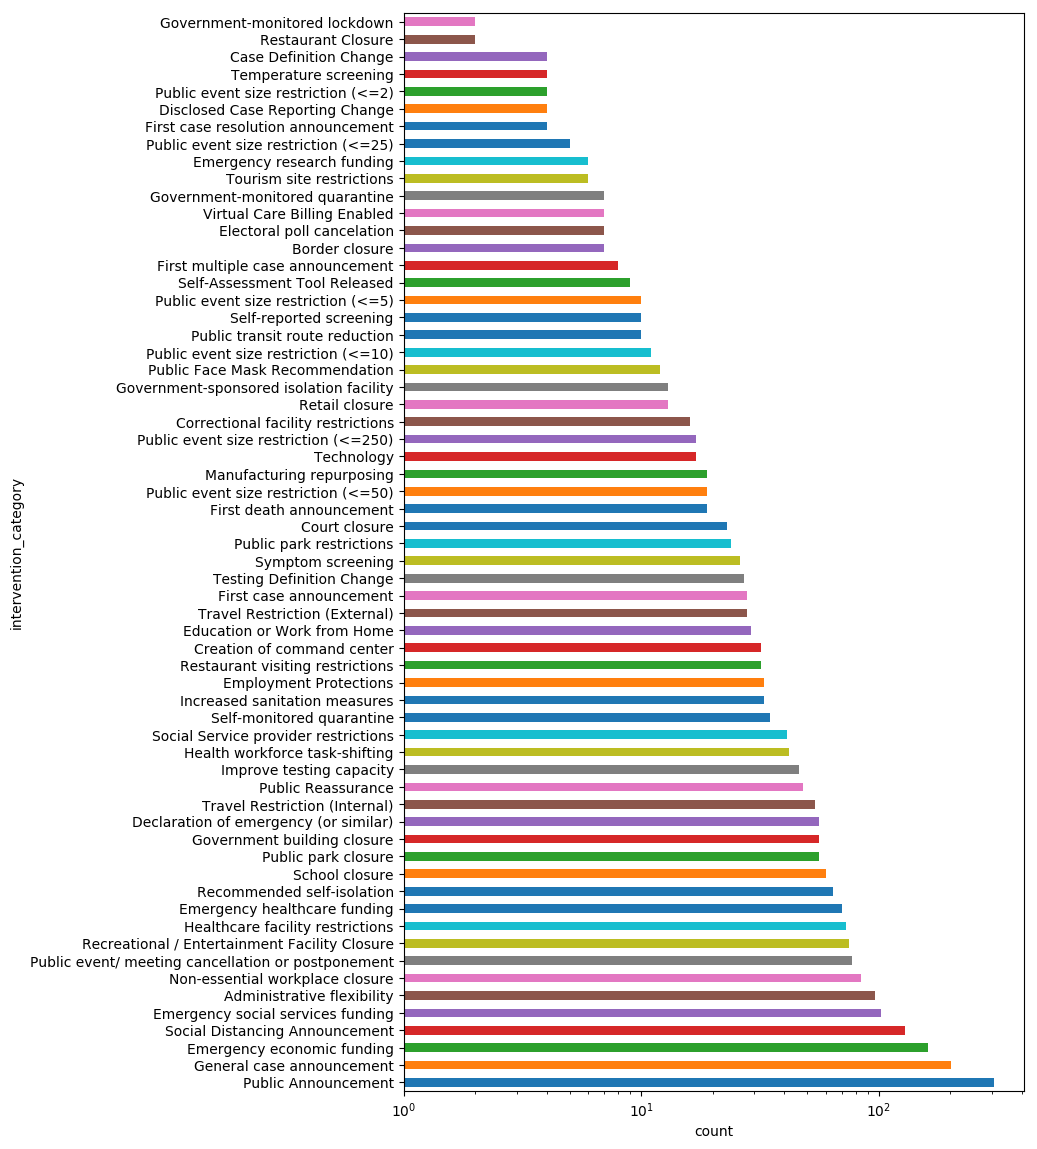

In [78]:

full_df.groupby(by="intervention_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')


# Sources

Looking at unique source urls, organizations, and source types

In [79]:
a = full_df['source_organization'].unique()
a.shape

(243,)

In [80]:
b = full_df['source_organization_2'].unique()

In [81]:
all_sources = list(set(a) | set(a))
len(all_sources)

243

## NPI: Fiscal Measures

Show investments by province or subregion

In [82]:
#fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='04-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')
provinces_fiscal = pd.DataFrame(dates)

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['cumulative'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    all_dates_df.set_index('start_date')
    all_dates_df = all_dates_df.groupby(by='start_date').sum()

    provinces_fiscal[g_name] = all_dates_df['cumulative']

#plt.yscale('log')
#plt.title('')
#plt.ylabel('Fiscal Interventions ($)')
#plt.xlabel('Date')

#provinces_fiscal

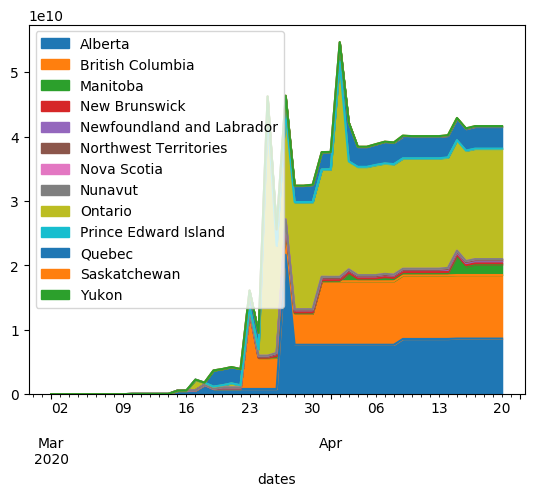

In [83]:
print("WARNING: Not Correct Yet")
provinces_fiscal.drop(['dates'], axis=1).plot.area()

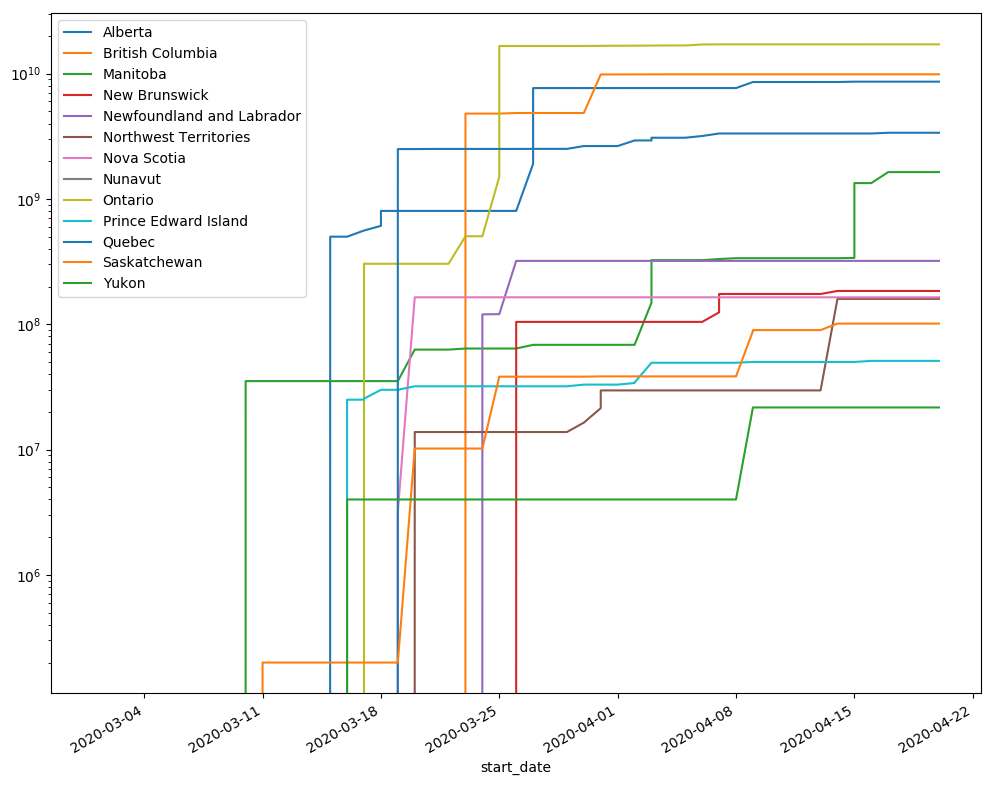

In [84]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='04-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

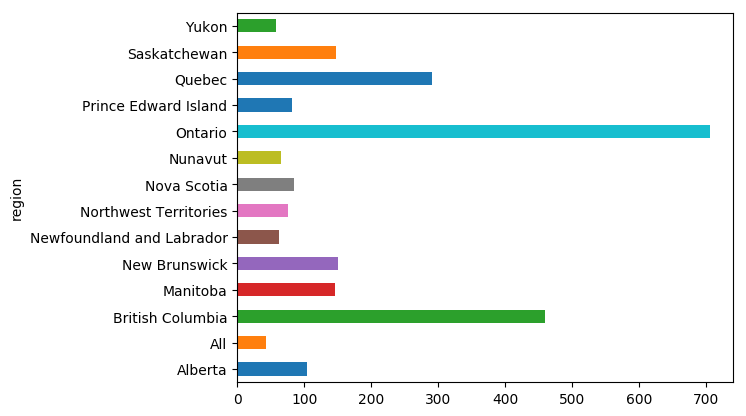

In [85]:
full_df.groupby(by=['region']).count().max(axis=1).plot.barh()

In [86]:
full_df.groupby(by=['region'])['start_date'].quantile(0.5).sort_values()

region
All                         2020-03-16 00:00:00
Nova Scotia                 2020-03-19 00:00:00
British Columbia            2020-03-23 00:00:00
Newfoundland and Labrador   2020-03-23 00:00:00
Nunavut                     2020-03-23 00:00:00
Saskatchewan                2020-03-23 00:00:00
Northwest Territories       2020-03-23 12:00:00
Ontario                     2020-03-24 00:00:00
Quebec                      2020-03-24 00:00:00
Prince Edward Island        2020-03-25 00:00:00
New Brunswick               2020-03-26 00:00:00
Yukon                       2020-03-27 00:00:00
Alberta                     2020-03-28 00:00:00
Manitoba                    2020-04-02 12:00:00
Name: start_date, dtype: datetime64[ns]

# NPI: Distribution of Events

In [87]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-03-24 00:00:00')

In [88]:
provinces_df['start_date'].quantile(0.5)

Timestamp('2020-03-24 00:00:00')

In [89]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-03-24 00:00:00')

In [90]:
median_dates = provinces_df.groupby(by='region')['start_date'].quantile(0.5)
median_dates

region
Alberta                     2020-03-27 00:00:00
British Columbia            2020-03-23 00:00:00
Manitoba                    2020-04-05 00:00:00
New Brunswick               2020-03-26 00:00:00
Newfoundland and Labrador   2020-03-23 00:00:00
Northwest Territories       2020-03-23 12:00:00
Nova Scotia                 2020-03-18 00:00:00
Nunavut                     2020-03-23 00:00:00
Ontario                     2020-03-23 00:00:00
Prince Edward Island        2020-03-25 00:00:00
Quebec                      2020-03-25 00:00:00
Saskatchewan                2020-03-23 00:00:00
Yukon                       2020-03-27 00:00:00
Name: start_date, dtype: datetime64[ns]

In [91]:
print("The median intervention dates for provinces and territories falls between ", median_dates.min(), " and ", median_dates.max())

The median intervention dates for provinces and territories falls between  2020-03-18 00:00:00  and  2020-04-05 00:00:00


In [92]:
cma_med_dates = full_df.dropna(subset=['subregion']).groupby(by=['subregion'])['start_date'].quantile(0.5)
cma_med_dates

subregion
Calgary              2020-04-02 00:00:00
Edmonton             2020-04-01 00:00:00
Gatineau             2020-03-24 00:00:00
Halifax              2020-03-22 00:00:00
Hamilton             2020-03-19 00:00:00
Kelowna              2020-03-24 00:00:00
Kitchener-Waterloo   2020-03-19 00:00:00
London               2020-03-30 00:00:00
Montreal             2020-03-24 00:00:00
Niagara              2020-03-21 00:00:00
Oshawa               2020-03-19 00:00:00
Ottawa               2020-04-06 00:00:00
Quebec City          2020-03-21 12:00:00
Regina               2020-03-20 00:00:00
Saskatoon            2020-03-23 00:00:00
St. John's           2020-03-23 12:00:00
Toronto              2020-03-21 00:00:00
Vancouver            2020-03-20 00:00:00
Victoria             2020-03-22 00:00:00
Windsor              2020-03-17 00:00:00
Winnipeg             2020-03-20 12:00:00
Name: start_date, dtype: datetime64[ns]

In [93]:
print("The median intervention dates for CMAs falls between ", cma_med_dates.min(), " and ", cma_med_dates.max())

The median intervention dates for CMAs falls between  2020-03-17 00:00:00  and  2020-04-06 00:00:00


DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')


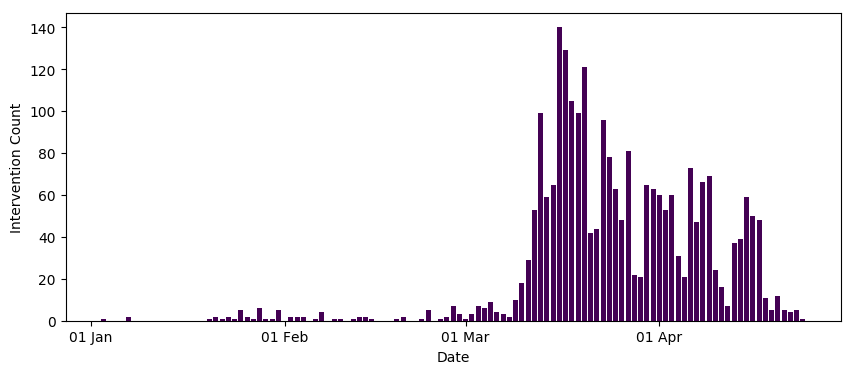

In [94]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,4))

xticks = pd.date_range(start='12-01-2019', end='03-31-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]
ts = full_df.groupby(by=['start_date'])['intervention_category'].count()

cmap = mpl.cm.get_cmap('viridis')
plt.bar(ts.index, ts.values, color=cmap(0))

plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
print(xticks)

DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')


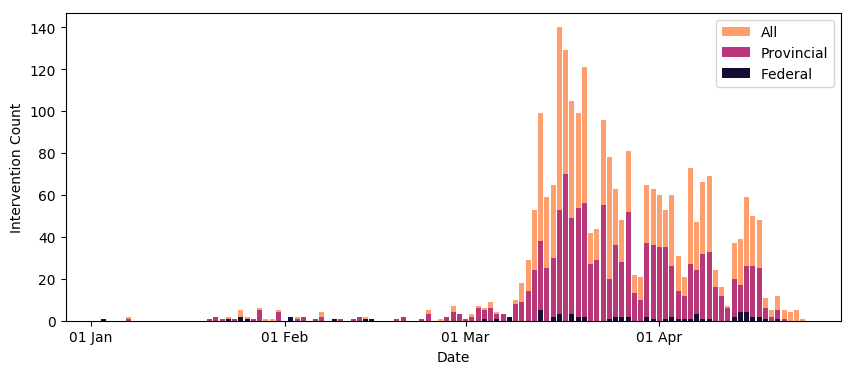

In [95]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,4))

xticks = pd.date_range(start='12-01-2019', end='04-19-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]


cmap = mpl.cm.get_cmap('magma')


ts = full_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.8), label='All')

ts = provinces_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.5), label='Provincial')

ts = federal_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.1), label='Federal')



plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
print(xticks)
plt.legend()

#ts = full_df.subtract(provinces_df).groupby(by=['start_date'])['intervention_category'].count()
#cmap = mpl.cm.get_cmap('viridis')
#plt.bar(ts.index, ts.values, color=cmap(.5), alpha=0.4)


In [96]:
names = full_df['region']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

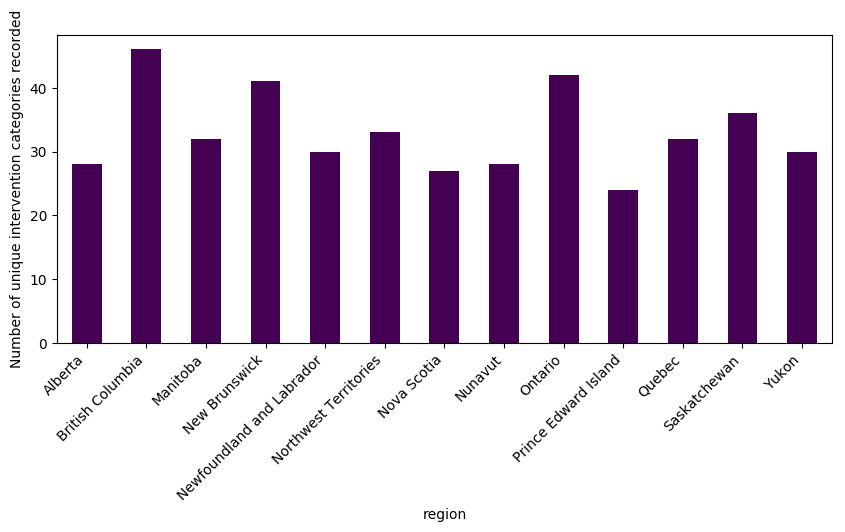

In [97]:
import matplotlib.ticker as ticker
provinces_df.dropna(subset=['region']).groupby(by=['region'])['intervention_category'].nunique().plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

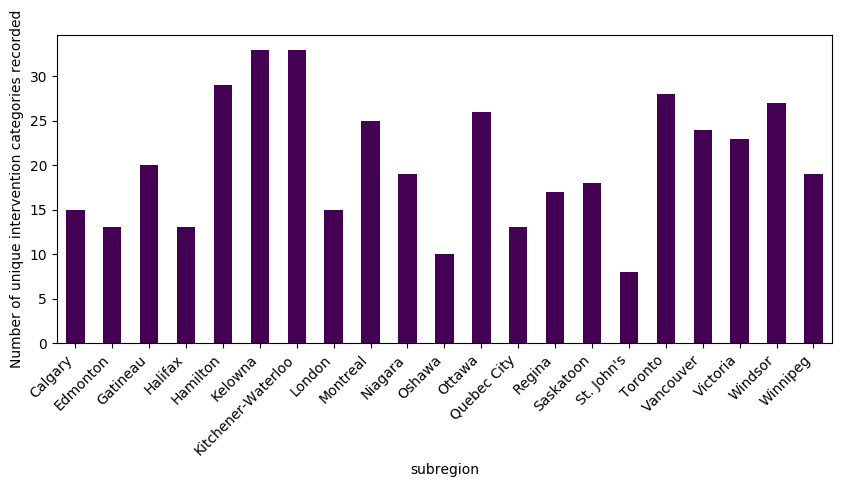

In [98]:
import matplotlib.ticker as ticker
subregions = full_df.dropna(subset=['subregion']).groupby(by=['subregion'])['intervention_category'].nunique()

subregions.plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


Text(0.5,0,'Number of unique Oxford interventions recorded')

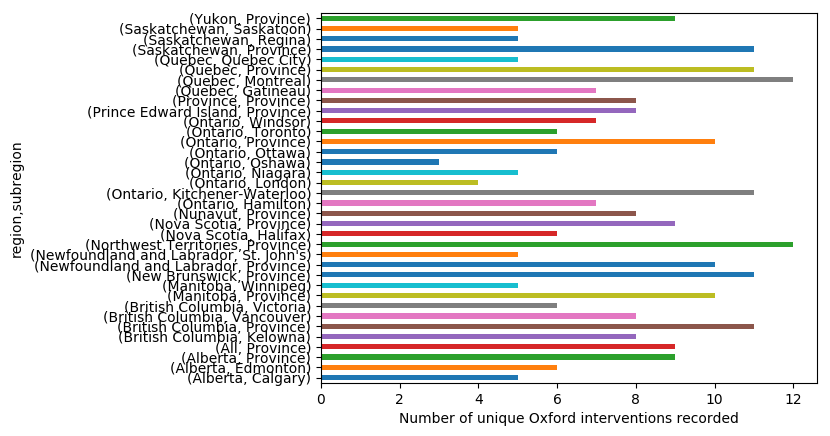

In [99]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford interventions recorded')


Text(0,0.5,'Unique Intervention Categories Recorded')

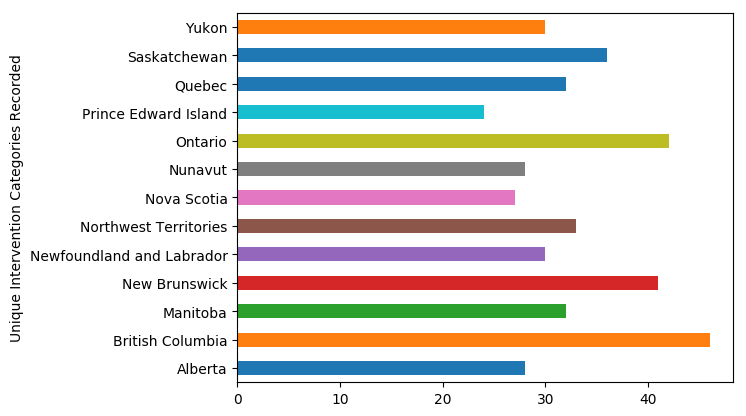

In [100]:
provinces_df.groupby(by='region')['intervention_category'].nunique().plot.barh()
plt.ylabel('Unique Intervention Categories Recorded')

Text(0.5,0,'Number of unique interventions recorded')

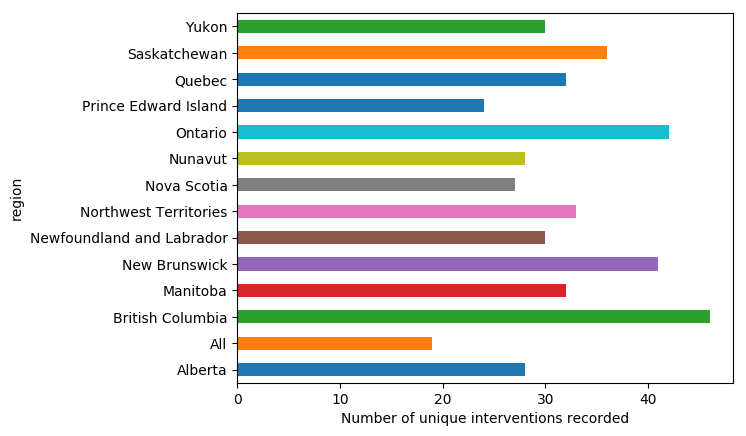

In [101]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


Text(0.5,0,'Number of unique Oxford response measures recorded')

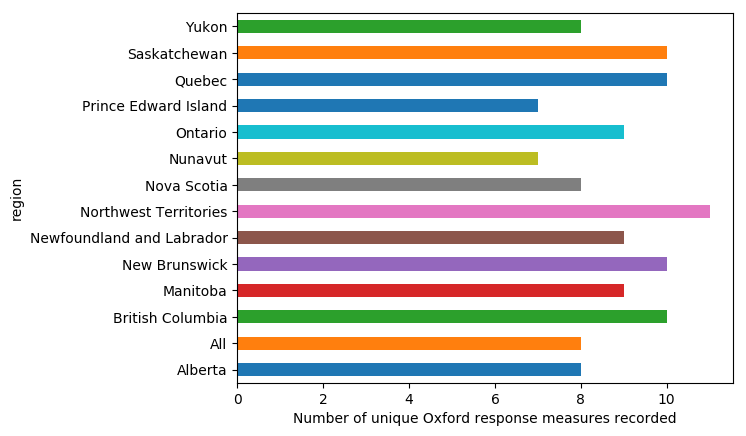

In [102]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford response measures recorded')


Text(0.5,0,'Oxford Fiscal Measure (CAD) recorded')

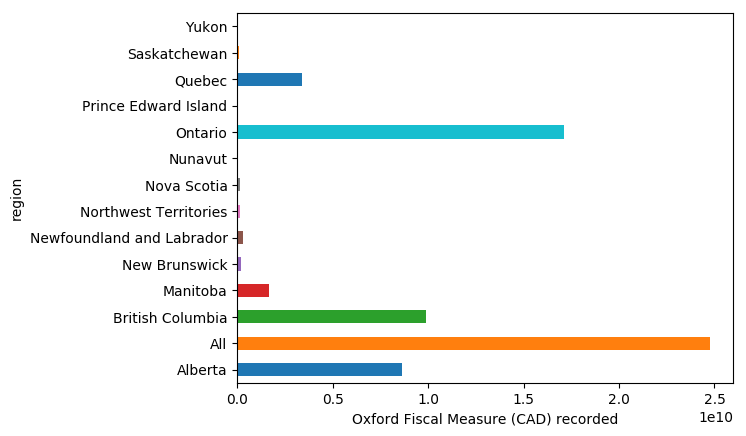

In [103]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum().plot.barh()
plt.xlabel('Oxford Fiscal Measure (CAD) recorded')


In [104]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum()

region
Alberta                      8.628300e+09
All                          2.474820e+10
British Columbia             9.875500e+09
Manitoba                     1.638265e+09
New Brunswick                1.845016e+08
Newfoundland and Labrador    3.205000e+08
Northwest Territories        1.595740e+08
Nova Scotia                  1.642000e+08
Nunavut                      0.000000e+00
Ontario                      1.711940e+10
Prince Edward Island         5.106000e+07
Quebec                       3.374500e+09
Saskatchewan                 1.013000e+08
Yukon                        2.170000e+07
Name: oxford_fiscal_measure_cad, dtype: float64

Text(0,0.5,'$ / person')

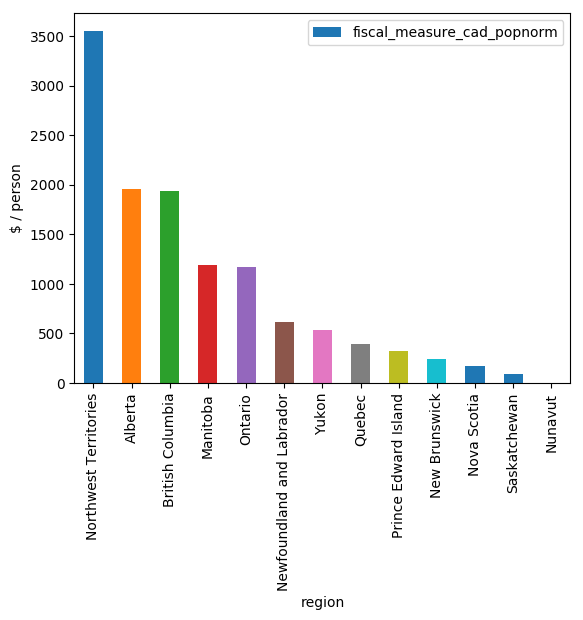

In [105]:
df = pd.DataFrame(provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum())
df['region'] = df.index
df = df.merge(population_df, on='region', how='left')
df['fiscal_measure_cad_popnorm'] = df['oxford_fiscal_measure_cad'] /  df['population_q1_2020']
df = df.sort_values(by='fiscal_measure_cad_popnorm', ascending=False)
df.plot.bar(x='region', y='fiscal_measure_cad_popnorm')
plt.ylabel("$ / person")

Text(0,0.5,'fiscal measures (CAD)')

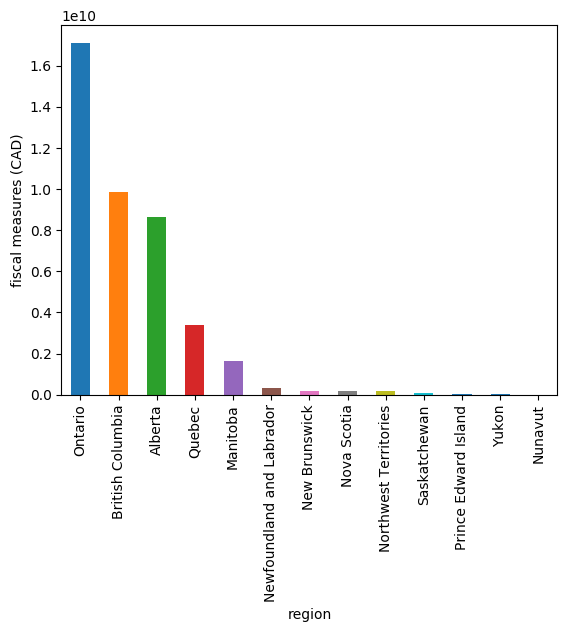

In [106]:
provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('fiscal measures (CAD)')

# Comparing Provincial and Municipal Interventions of the Same Type

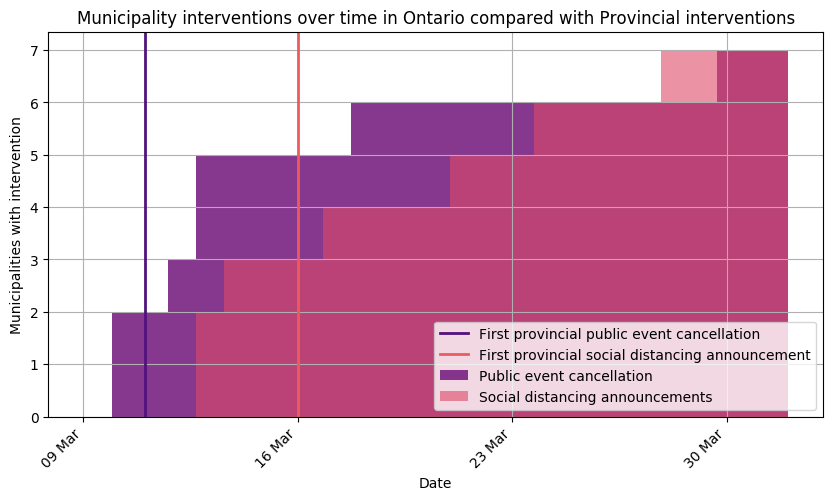

In [107]:
from matplotlib.dates import MO
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)

ont_df = full_df[full_df['region'] == 'Ontario']

cmap = mpl.cm.get_cmap('magma')

soc = ont_df[ont_df['intervention_category'] == 'Social Distancing Announcement']
#rec = ont_df[ont_df['intervention_category'] == 'Recreational / Entertainment Facility Closure']
pem = ont_df[ont_df['intervention_category'] == 'Public event/ meeting cancellation or postponement']
#park = ont_df[ont_df['intervention_category'] == 'Public park closure']

start = datetime(2020, 3, 9)
end = datetime(2020, 4, 1) 
drange=(start, end)

pem.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.35),  alpha=0.9, cumulative=True, label='Public event cancellation')
#rec.groupby('subregion').min()['start_date'].hist(bins=30, color=cmap(0.8), alpha=0.5, cumulative=True, label='Recreational / Entertainment Facility Closure')
soc.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.6), alpha=0.6, cumulative=True, label='Social distancing announcements')
#park.groupby('subregion').min()['start_date'].hist(color='red', alpha=0.5, label='Public park closure')

a = soc[soc['subregion'].isna()]
soc_ont = a[a['intervention_category'] == 'Social Distancing Announcement']
soc_ont_date = soc_ont['start_date'].min()

#a = rec[rec['subregion'].isna()]
#rec_ont = a[a['intervention_category'] == 'Recreational / Entertainment Facility Closure']
#rec_ont_date = rec_ont['start_date'].min()

plt.axvline(x=rec_ont_date, label='First provincial public event cancellation', color=cmap(0.25), linewidth=2)
plt.axvline(x=soc_ont_date, label='First provincial social distancing announcement', color=cmap(0.65), linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower right")
plt.title('Municipality interventions over time in Ontario compared with Provincial interventions')

plt.xlabel('Date')
plt.ylabel('Municipalities with intervention')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)


## Heatmap of cumulative municipal top intervention categories

In [108]:
# Thanks to matplotlib documentation for this

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [109]:
top_interventions = full_df.groupby(by='subregion')['intervention_category'].value_counts() \
    .groupby(by='intervention_category') \
    .count() \
    .sort_values(ascending=False)[:10] \
    
top_interventions

intervention_category
Public Announcement                                   19
Public event/ meeting cancellation or postponement    19
Social Distancing Announcement                        18
Recreational / Entertainment Facility Closure         18
Public park closure                                   17
Administrative flexibility                            16
Declaration of emergency (or similar)                 16
Government building closure                           15
Emergency social services funding                     13
Social Service provider restrictions                  13
Name: intervention_category, dtype: int64

In [110]:
cma_population= pd.DataFrame([['Toronto', 5429524],
                ["Montreal", 3519595],
                ["Vancouver", 2264823],
                ["Calgary", 1237656],
                ["Edmonton", 1062643],
                ["Ottawa", 989657],
                ["Gatineau", 989657],
                ["Winnipeg", 711925],
                ["Quebec City", 705103],
                ["Hamilton", 693645],
                ["Kitchener-Waterloo", 535154],
                ["London", 383437],
                ["Victoria", 335696],
                ["Halifax", 316701],
                ["Oshawa", 308875],
                ["Windsor", 287069],
                ["Saskatoon", 245181],
                ["Niagara", 229246],
                ["Regina", 214631],
                ["St. John's", 178427],
                ["Kelowna", 151957]], columns=['subregion', 'population'])
# Population numbers from Canadian Census 2016

In [111]:
filtered_df = full_df[full_df['intervention_category'].isin(top_interventions.index.values)]
#filtered_df = filtered_df.groupby(by=['subregion', 'start_date']).nunique()['intervention_category']
filtered_df = filtered_df.merge(cma_population, on='subregion')
filtered_df = filtered_df.sort_values(by='population', ascending=False)
soc_count = filtered_df.groupby(by=['subregion', 'intervention_category'], sort=False).min()['start_date']
#soc_count = soc_count.merge(cma_population, on='subregion')

xticks = pd.date_range(start='03-08-2020', end='04-19-2020', freq='W')


col = ['subregion', *xticks.date]
cma_df = pd.DataFrame()

for subregion in soc_count.index.get_level_values(0).unique():
    dates = soc_count.loc[[subregion]].reset_index()
    empty_row = [subregion]
    for week_end in xticks.values:
        count = dates[dates['start_date'] < week_end]['intervention_category'].count()
        empty_row.append(count)
    cma_df = cma_df.append([empty_row])
    
cma_df.columns = col
cma_df = cma_df.set_index('subregion')

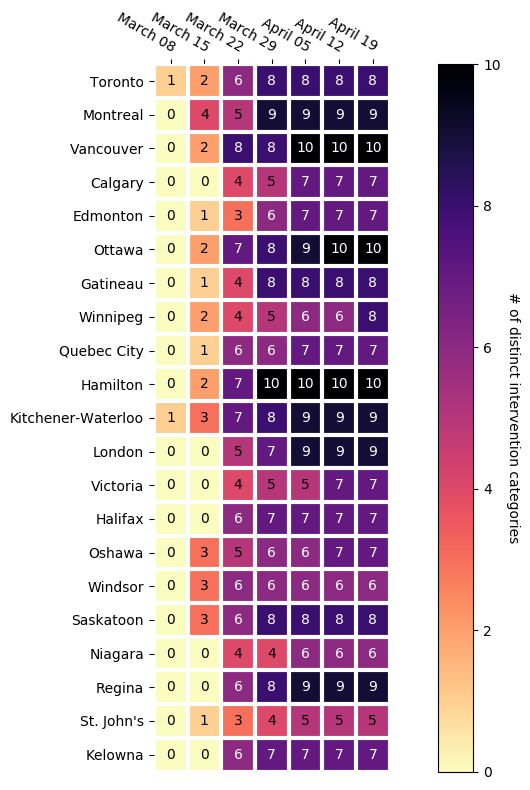

In [112]:
#fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,8))

nice_date = [x.strftime('%B %d') for x in cma_df.columns.values]

im, cbar = heatmap(cma_df.values, cma_df.index.values, nice_date, ax=ax,
                   cmap="magma_r", cbarlabel="# of distinct intervention categories")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.show()

# Mobility comparison

In [113]:
ox = full_df['oxford_government_response_category'].unique()

In [114]:
ox[2]

'S3 Cancel public events'

In [115]:
gb = provinces_df.groupby(by='region')
for gb_name, g in gb:
    for intervention in ox:
        rows = g[g['oxford_government_response_category'] == intervention]
        if ox[2] in rows['oxford_government_response_category']: # public events
            print(rows['oxford_closure_code'])

In [116]:
g['oxford_government_response_category'].mode()

0    S5 Public info campaigns        
1    S7 International travel controls
dtype: object

## Clustering Representation

For now just showing clustering on hand-applied labels.

In [117]:
>>> from sklearn import preprocessing
df = full_df.fillna(-1)

le_re = preprocessing.LabelEncoder()
le_re.fit(df['region'].astype(str).values)
le_ic = preprocessing.LabelEncoder()
le_ic.fit(df['intervention_category'].astype(str).values)
le_ec = preprocessing.LabelEncoder()
le_ec.fit(df['enforcement_category'].astype(str).values)
le_tp = preprocessing.LabelEncoder()
le_tp.fit(df['target_population_category'].astype(str).values)

LabelEncoder()

In [118]:
y = le_ic.transform(df['intervention_category'].astype(str))
X = np.array([
    le_re.transform(df['region'].astype(str)),
    le_ec.transform(df['enforcement_category'].astype(str)),
    le_tp.transform(df['target_population_category'].astype(str)),
    df['oxford_closure_code'].astype(int),
    df['oxford_public_info_code'].astype(int),
    df['oxford_travel_code'].astype(int),
    df['oxford_geographic_target_code'].astype(int)]).T

In [119]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X, y)
X_embedded

array([[-29.534998 ,  29.924355 ],
       [-29.534973 ,  29.924353 ],
       [-28.543045 , -20.591686 ],
       ...,
       [ 25.668165 ,   1.9160745],
       [  5.915214 , -19.52541  ],
       [  3.3068748, -19.177185 ]], dtype=float32)

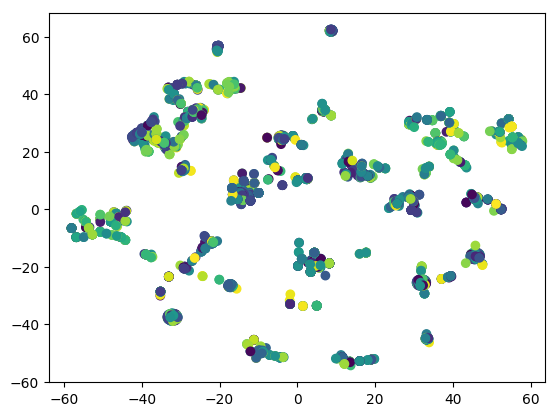

In [120]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)

# LDA on Intervention Text

Topics on full text just find regions. Need to remove all location-based markers from full text.

In [121]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text 

We choose to leave out geography-related words by marking them as stop words. This seems to prevent the model from picking up on the strong geographical topics in our selection of data and helps it discover other useful clusters.

In [122]:
r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]
stop_words = text.ENGLISH_STOP_WORDS.union(geo_stop_words)

We automate the selection of the number of topics by calculating the perplexity score for the model and minimizing across the number of topics.

In [123]:
def topic_selection(tf, tmax, tstep, debug=False):
    topic_sizes = np.arange(1, tmax, tstep)
    topic_ll = []
    topic_perplexity = []
    models = []
    for k in topic_sizes:


        n_topics = k

        lda = LatentDirichletAllocation(n_components=n_topics, 
            max_iter=10, 
            learning_method='online',
            learning_offset=50.,
            random_state=3).fit(tf)

        # use perplexity for now.. try gensim coherence later
        # see https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb
        topic_ll.append( lda.score(tf) )
        p = lda.perplexity(tf)
        topic_perplexity.append( p )
        models.append(lda)
        
        if (debug):
            print('Topics: ', k, ' perplexity ', p)
    
    idx = np.where(topic_perplexity == np.amin(topic_perplexity))[0][0]
    selected_lda = models[idx]
    ntopics = topic_sizes[idx]
    return topic_sizes, topic_perplexity, selected_lda, ntopics

In [140]:
def show_topk_words(lda, k, tf_feature_names):
    n_top_words = k
    for topic_i, topic in enumerate(lda.components_):
        print( "Topic ", topic_i )
        print( "Words: ", [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )
        

### Full Source Text

Here we apply LDA to the full text of each source (except french sources)

In [125]:
len(full_df['source_url'].unique()) / full_df.shape[0]

0.5748598879103283

In [126]:
# Remove french
engl_df = full_df[full_df['region'] != 'Quebec']
full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
data = full_text.values
data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
data = [re.sub("\'", "", text) for text in data] # remove quotes
len(data)

1276

In [127]:
n_words = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words=stop_words)
tf = tf_vectorizer.fit_transform( data )
tf_feature_names = tf_vectorizer.get_feature_names()

In [128]:
topic_sizes, topic_perplexity, lda, ntopics = topic_selection(tf, 40, 2)
print("Selected ", ntopics, " topics")

Selected  17  topics


Text(0,0.5,'perplexity')

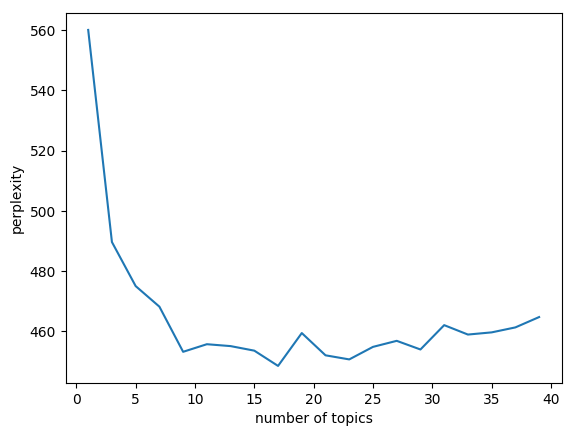

In [129]:
plt.plot(topic_sizes, topic_perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')

In [130]:
show_topk_words(lda, 15, tf_feature_names)

Topic  0
said
zone
cases
higgs
russell
individual
aged
brunswickers
fredericton
region
number
confirmed
50
benefit
60
Words:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Topic  1
support
government
canada
covid
19
traffic
provide
order
health
closed
workers
financial
businesses
billion
march
Words:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Topic  2
health
public
chief
officer
covid
19
measures
medical
situation
canada
coronavirus
dr
information
spread
government
Words:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Topic  3
canada
covid
19
research
canadians
nwt
canadian
government
health
minister
honourable
gnwt
world
help
projects
Words:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Topic  4
islanders
pei
morrison
pm
saturday
stores
minister
released
hours
special
government
alcohol
restrictions
max

# LDA on Intervention Summary Text

In [131]:
full_summaries = full_df['intervention_summary'].drop_duplicates().astype(str)

In [132]:

n_words = 200

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words='english')
tf = tf_vectorizer.fit_transform( full_summaries )
tf_feature_names = tf_vectorizer.get_feature_names()

In [133]:
topic_sizes, topic_perplexity, lda, ntopics = topic_selection(tf, 40, 2)
print("Selected ", ntopics, " topics")

Selected  7  topics


Text(0,0.5,'perplexity')

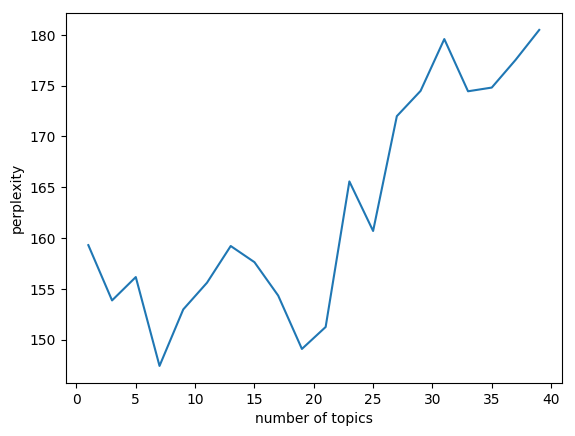

In [134]:
plt.plot(topic_sizes, topic_perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')

In [ ]:
show_topk_words(lda, 20, tf_feature_names)